<a href="https://colab.research.google.com/github/sahilsama/Gender-classification-and-Age-estimation-model/blob/main/Gender_and_Age_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/My Drive/UTFface/crop_part1/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/drive/My Drive/UTFface/crop_part1/76_...,76,1
1,/content/drive/My Drive/UTFface/crop_part1/76_...,76,1
2,/content/drive/My Drive/UTFface/crop_part1/77_...,77,0
3,/content/drive/My Drive/UTFface/crop_part1/77_...,77,0
4,/content/drive/My Drive/UTFface/crop_part1/77_...,77,0


In [ ]:
# Map labels for gender
gender_dict = {0:'Male', 1:'Female'}



## Exploratory Data Analysis

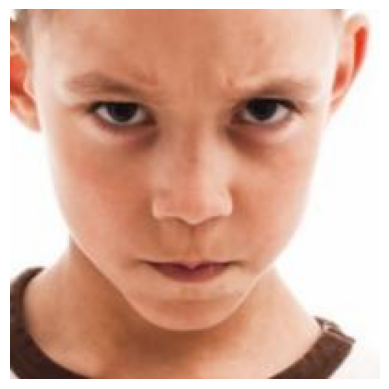

In [ ]:
from PIL import Image
img = Image.open(df['image'][69])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

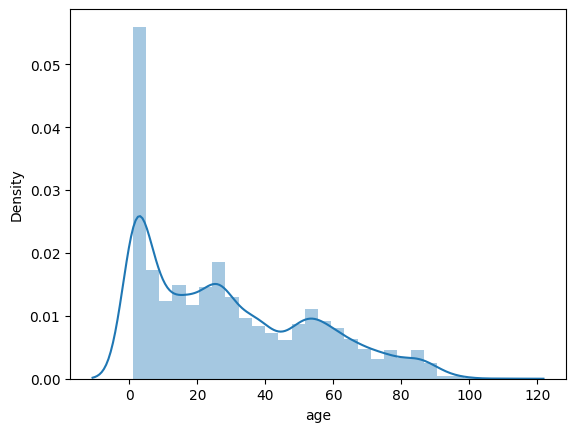

In [ ]:
sns.distplot(df['age'])

In [58]:
# Map 1 to 'Male' and 0 to 'Female' 3 either both gender or no gender
df = df[df['gender'] != 3]
print(df['gender'].unique())

[1 0]


<Axes: ylabel='count'>

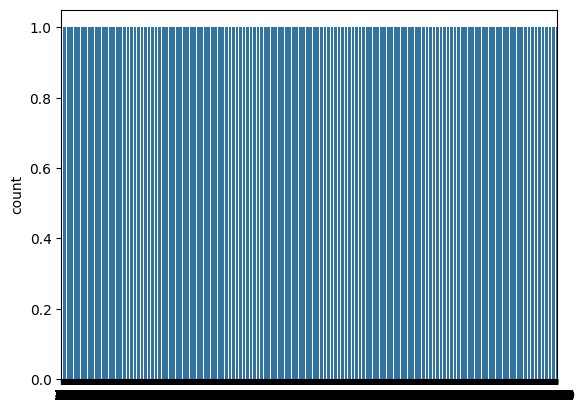

In [60]:
sns.countplot(df['gender'])

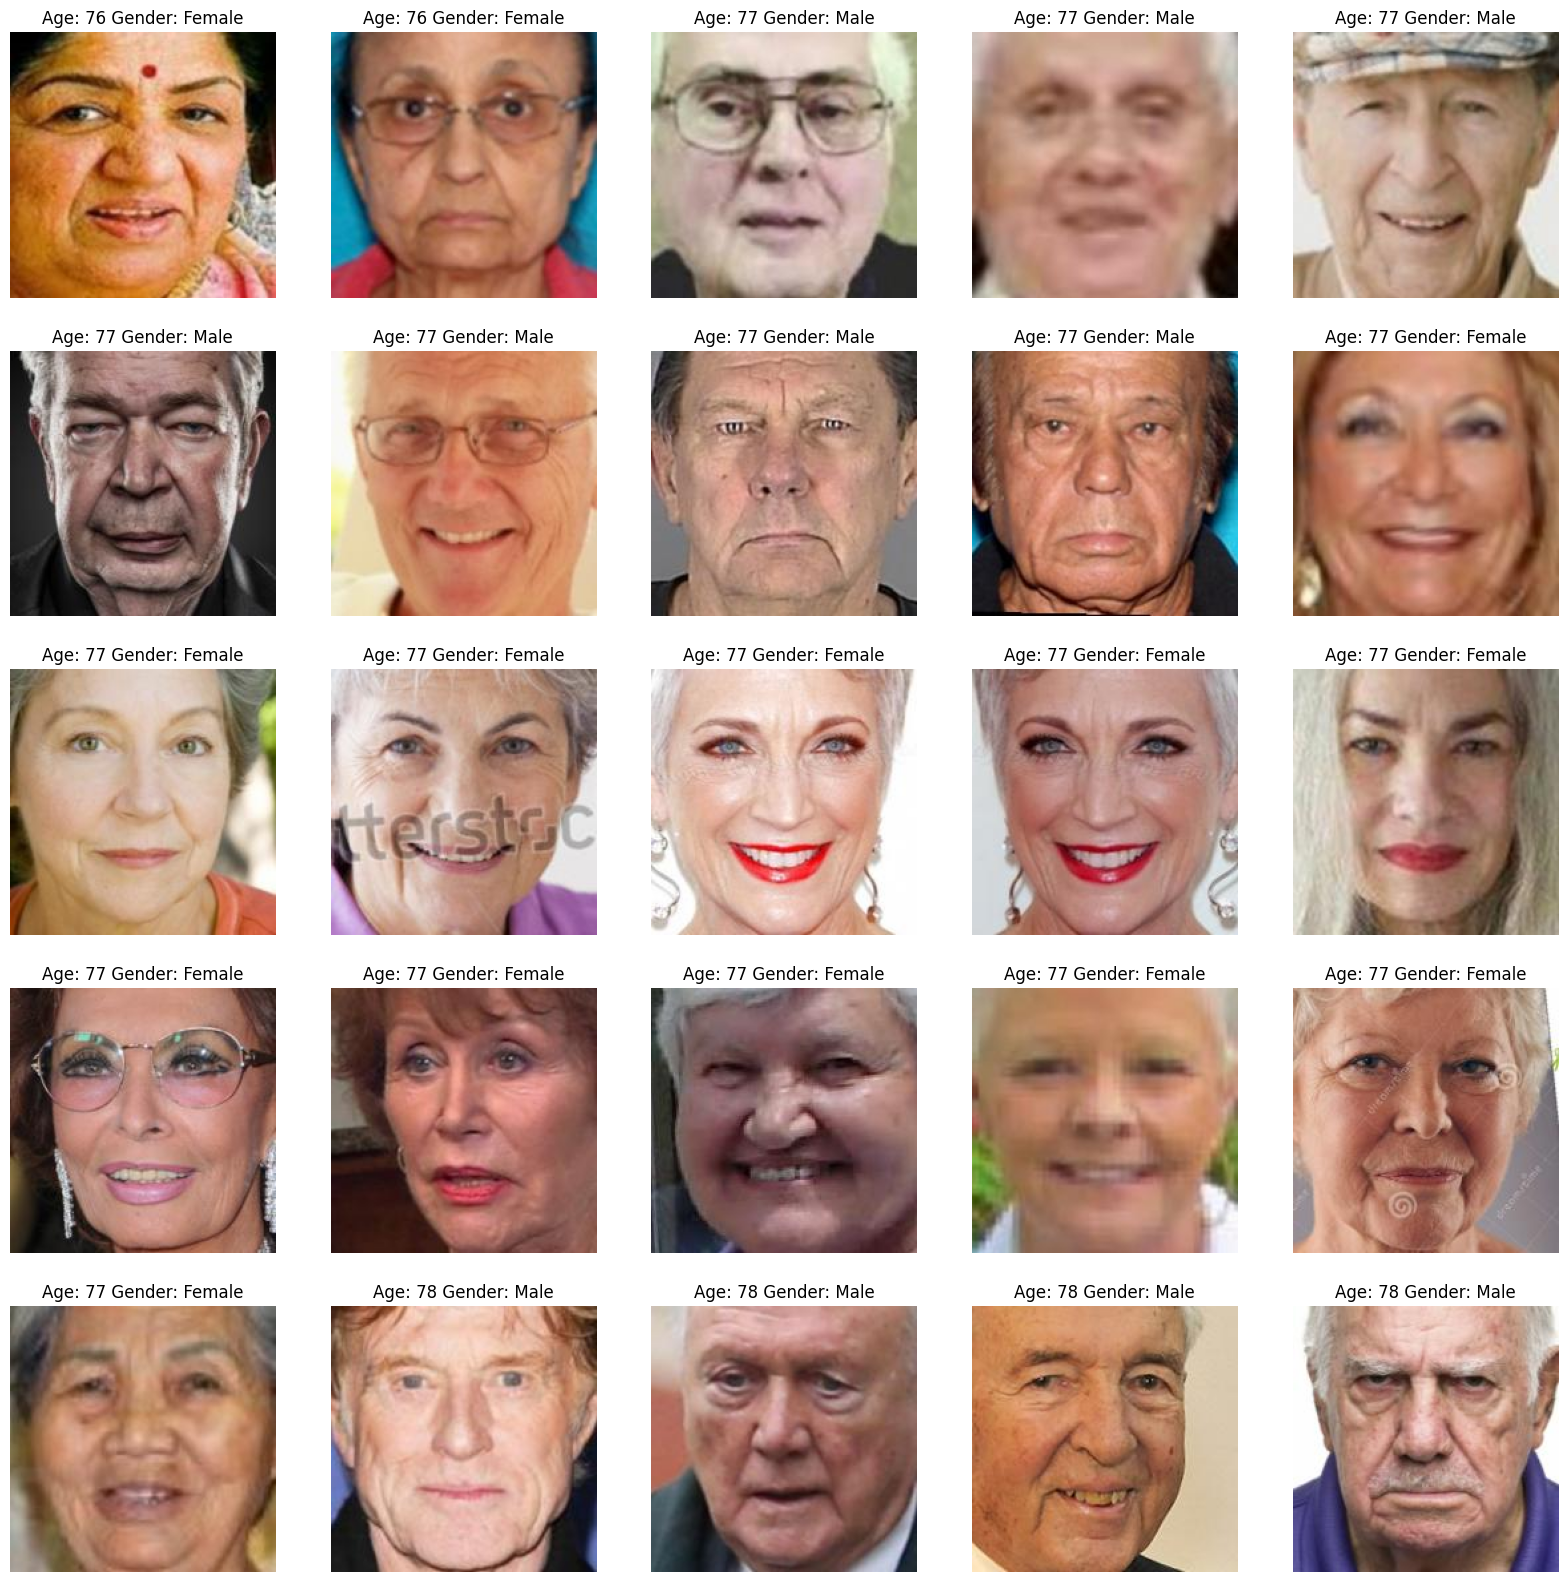

In [55]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


## Feature Extraction

In [56]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [53]:
X = extract_features(df['image'])

  0%|          | 0/9780 [00:00<?, ?it/s]

In [61]:
X.shape

(9780, 128, 128, 1)

In [62]:
# normalize the images
X = X/255.0

In [73]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
print("x shape:", X.shape)
print("y_gender shape:", y_gender.shape)
print("y_age shape:", y_age.shape)

x shape: (9780, 128, 128, 1)
y_gender shape: (9779,)
y_age shape: (9779,)


In [64]:
input_shape = (128, 128, 1)

## Model Creation

In [65]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

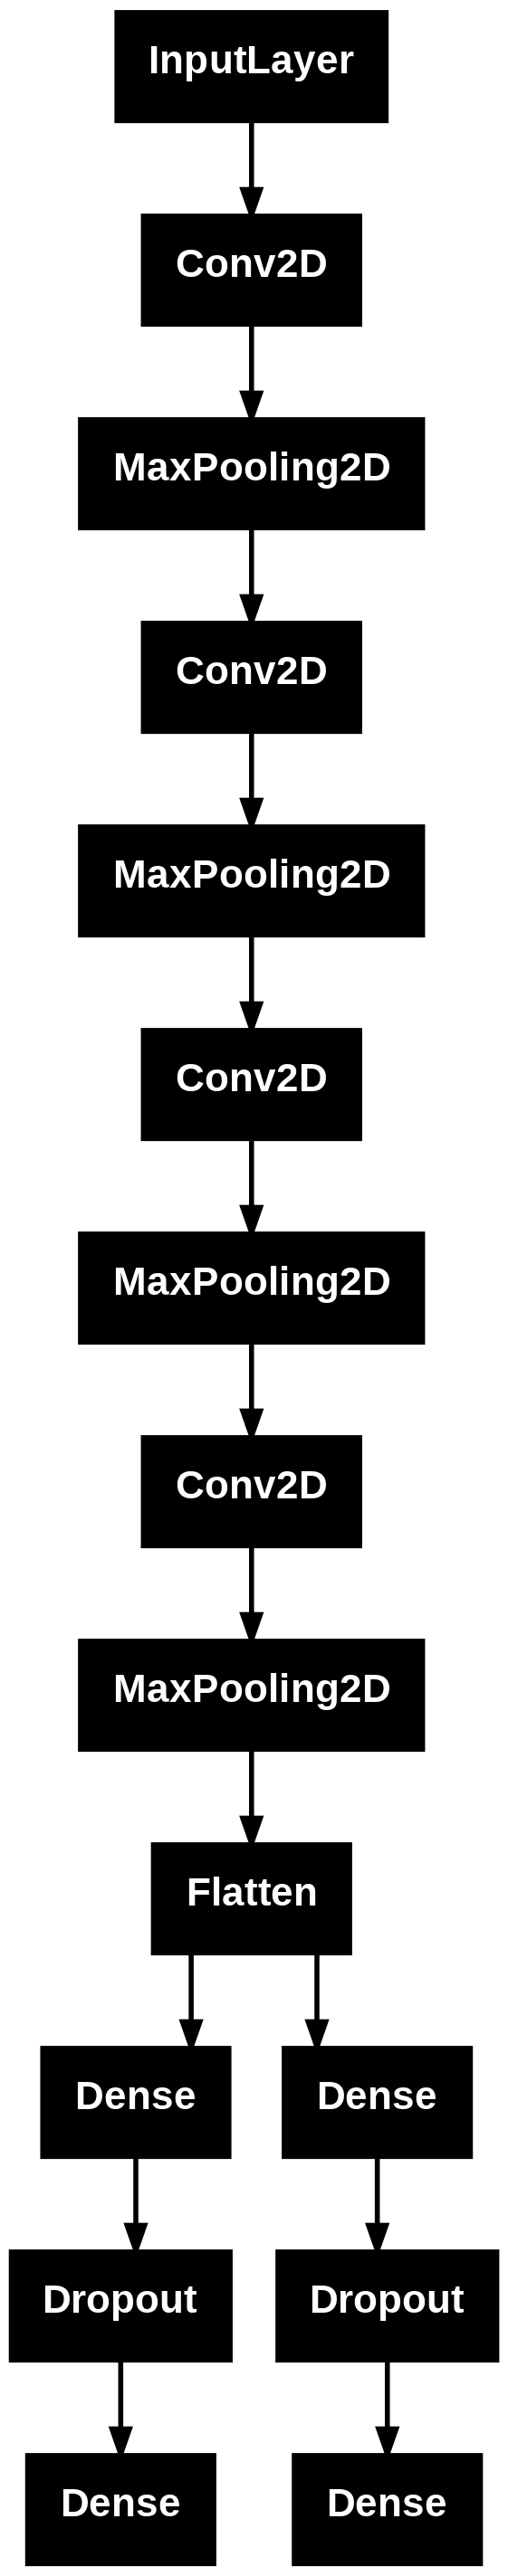

In [66]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [76]:
# train model
print("x shape:", X.shape)
print("y_gender shape:", y_gender.shape)
print("y_age shape:", y_age.shape)

# Align the sizes
min_samples = min(len(X), len(y_gender), len(y_age))

# Truncate all datasets to the same size
X = X[:min_samples]
y_gender = y_gender[:min_samples]
y_age = y_age[:min_samples]

# Verify the new shapes
print("After alignment:")
print("x shape:", X.shape)
print("y_gender shape:", y_gender.shape)
print("y_age shape:", y_age.shape)

# Now fit the model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


x shape: (9780, 128, 128, 1)
y_gender shape: (9779,)
y_age shape: (9779,)
After alignment:
x shape: (9779, 128, 128, 1)
y_gender shape: (9779,)
y_age shape: (9779,)
Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - age_out_loss: 11.4642 - age_out_mae: 11.4642 - gender_out_accuracy: 0.7362 - gender_out_loss: 0.5333 - loss: 11.9975 - val_age_out_loss: 12.1609 - val_age_out_mae: 12.1531 - val_gender_out_accuracy: 0.5363 - val_gender_out_loss: 0.6364 - val_loss: 12.7882
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - age_out_loss: 10.3394 - age_out_mae: 10.3394 - gender_out_accuracy: 0.7512 - gender_out_loss: 0.5106 - loss: 10.8500 - val_age_out_loss: 11.6886 - val_age_out_mae: 11.6245 - val_gender_out_accuracy: 0.5072 - val_gender_out_loss: 0.7081 - val_loss: 12.3276
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - age_out_loss: 9.3198 - age_out_mae: 9.3198 - gender_out_accuracy: 0.7770 - gender_out_loss: 0.4736 - loss: 9.7935 - val_age_out_loss: 7.6945 - val_age_out_mae

## Plot the Results

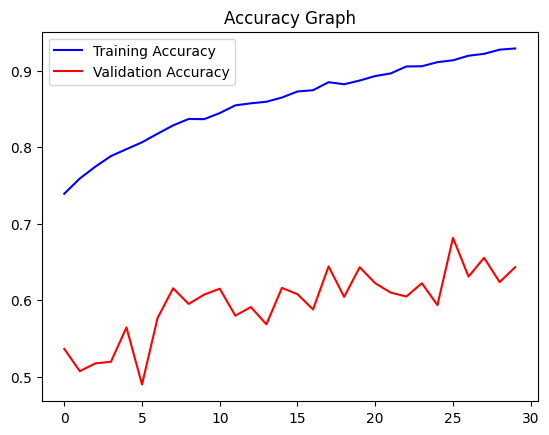

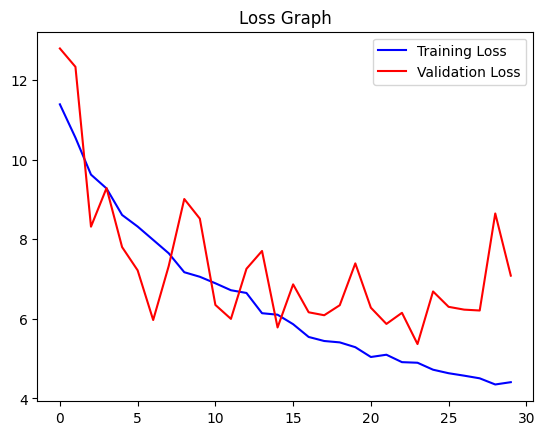

In [77]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

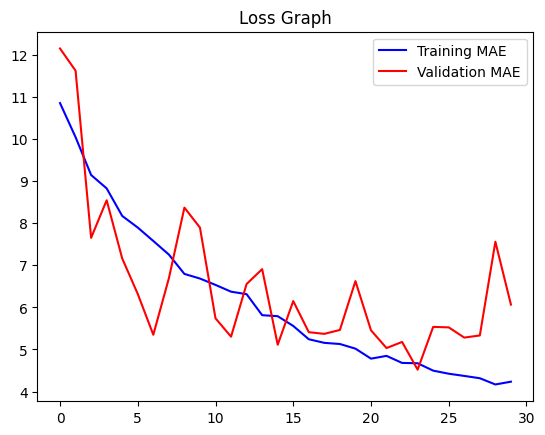

In [78]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Male Original Age: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Gender: Male Predicted Age: 5 - 8


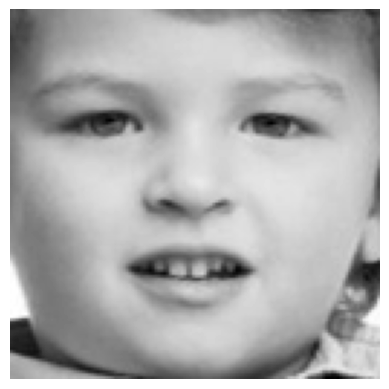

In [94]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:",  pred_age,"-",pred_age+3)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Gender: Female Predicted Age: 37 - 40


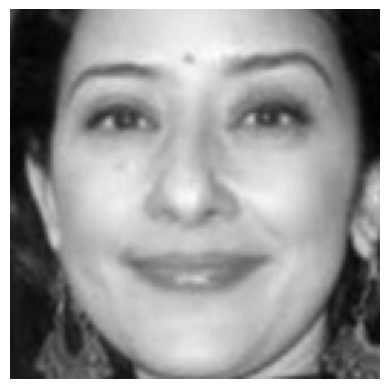

In [93]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age,"-",pred_age+3)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Gender: Female Predicted Age: 62 - 66


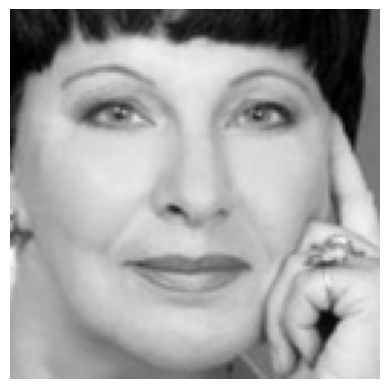

In [97]:
image_index = 1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:",  pred_age-1,"-",pred_age+3)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');